In [1]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from skimage.morphology import remove_small_objects
import nibabel as nib
import scipy.stats
from scipy.stats import mannwhitneyu, ttest_ind, ranksums,wilcoxon
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.stats import norm
from collections import Counter
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer 
from scipy.stats import sem
from statsmodels.stats.multitest import multipletests

In [113]:
def threshold_tract_vol_by_intensity(vol_tract,intensity_val):
    vol_output = np.zeros_like(vol_tract)
    vol_output[vol_tract == intensity_val] = 1
    #vol_output[vol_tract == intensity_val + 1000] = 1
    return vol_output


def extract_mean_diff(vol,vol_tract,erode_vol=False):

    vol = np.nan_to_num(vol)
    
    if np.count_nonzero(vol_tract) < 20:
        print("potentially bad vol!")

    ## small dilation kernel really for brainstem seg to avoid synthseg weird segmentation at boundaries/capture lesions
    if erode_vol is True:
        strel_dil = np.ones((5, 5, 5))
        vol_tract = binary_dilation(vol_tract, structure=strel_dil)
    
    masked_array = vol * vol_tract
    mean_intensity = np.nan_to_num(np.sum(masked_array)/np.sum(vol_tract))

    return mean_intensity


def extract_volume(vol,erode_vol=False):
    vol = np.nan_to_num(vol)
    
    ## small dilation kernel really for brainstem seg to avoid synthseg weird segmentation at boundaries/capture lesions
    if erode_vol is True:
        strel_dil = np.ones((5, 5, 5))
        vol = binary_dilation(vol, structure=strel_dil)
    
    if np.count_nonzero(vol) < 20:
        print(" ")
        print("   potentially bad vol!")
        print(" ")

    return np.count_nonzero(vol)



def dilate_binary_vol(vol):
    struct_element = np.ones((7, 7, 7), dtype=bool)
    vol_dilated = binary_dilation(vol, structure=struct_element) 
    
    return vol_dilated
    


### DICE ###
def overlap_score_simple(array1, array2):
     

    # Calculate intersection
    intersection = np.sum(array1 & array2)  
    sum_mask1 = np.sum(array1)
    sum_mask2 = np.sum(array2)

    if sum_mask1 + sum_mask2 == 0:  # no intensities present in either. Just set to 0
        ovr_score = 0.0
    else:
        ovr_score = (2. * intersection)/(sum_mask1)

    return ovr_score


    
def list_base_subdirectories(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]


def find_repeats(lst):
    counts = {}
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1  
    repeats = [item for item, count in counts.items() if count > 1]   
    return repeats

 
    
    
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2

# adapted from https://github.com/Netflix/vmaf/
def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

# adapted from https://github.com/Netflix/vmaf/
def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)

# adapted from https://github.com/Netflix/vmaf/
def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

# adapted from https://github.com/Netflix/vmaf/
def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

# adapted from https://github.com/Netflix/vmaf/
def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    print("aucs are: ", aucs)
    return calc_pvalue(aucs, delongcov)




def identify_non_outliers(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        non_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        return non_outliers, outliers


def plot_differences(label_names,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['mathtext.default'] = 'regular'

    num_labels = len(label_names)
    print("num labels is: ", num_labels)

    spacing = 20

    fig = plt.figure(figsize=figsize)

    plot_area = [0.3, 0.3, 0.6, 0.6]
    ax = fig.add_axes(plot_area)

    p_array = []

    control_position_list = []
    patient_position_list = []

    y_max = max(np.max(controls), np.max(patients))
    for i, label_name in enumerate(label_names):
        control_data = controls[:, i]
        patient_data = patients[:, i]
        
        # only show extreme outliers (Q1/Q3 += 3IQ)
        control_non_outliers, control_outliers = identify_non_outliers(control_data)
        patient_non_outliers, patient_outliers = identify_non_outliers(patient_data)

        # plot positions
        control_position = i * spacing - 1.5
        patient_position = i * spacing + 6.5

        control_position_list.append(control_position)
        patient_position_list.append(patient_position)

        data = [control_non_outliers, patient_non_outliers]
        positions = [control_position, patient_position]
        vp = plt.violinplot(data, positions=positions, widths=8, showextrema=False, showmedians=True)

        # Color the violin plots
        vp['bodies'][0].set_facecolor('#1F85DE')   # Control violin plot
        vp['bodies'][0].set_edgecolor('black')
        vp['bodies'][0].set_alpha(0.7)

        vp['bodies'][1].set_facecolor('#DE781F')    # Patient violin plot
        vp['bodies'][1].set_edgecolor('black')
        vp['bodies'][1].set_alpha(0.7)


        medianprops = dict(linestyle='-', linewidth=2, color='black')
        boxprops = dict(linestyle='-', linewidth=2, color='black')
        flierprops = dict(marker='o', markerfacecolor='none', markersize=8, linestyle='none', markeredgecolor='black',markeredgewidth=2)
        whiskerprops = dict(linewidth=2)
        plt.boxplot([control_non_outliers],positions=[control_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)
        plt.boxplot([patient_non_outliers],positions=[patient_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)


        for line in vp['cmedians'].get_segments():
            vp['cmedians'].set_edgecolor('black')

        median_segments = vp['cmedians'].get_segments()
        new_median_segments = []
        for seg in median_segments:
            # seg is a list of two points [x1, y1], [x2, y2]
            mid_point_x = np.mean([seg[0][0], seg[1][0]])
            # Adjust x-coords to shorten the line
            new_seg = [[mid_point_x - 2.2, seg[0][1]], [mid_point_x + 2.2, seg[1][1]]]  # Change 0.5 to adjust the length
            new_median_segments.append(new_seg)

        vp['cmedians'].set_segments(new_median_segments)
        
        # Plot the extreme outliers
        plt.scatter(np.full_like(control_outliers, control_position), control_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)
        plt.scatter(np.full_like(patient_outliers, patient_position), patient_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)


        ###################    

        # 2-tailed Wilcoxon rank-sum
        stat, p = ranksums(control_data, patient_data, alternative='two-sided')

        p_array.append(p)

    # consolidate for FDR correction
    p_array_corrected = multipletests(p_array, method='fdr_bh')[1] 

    for i, label_name in enumerate(label_names):    
        print("label name: ", label_name,  "    uncorrected p_value: ", p_array[i], "    corrected p_value: ", p_array_corrected[i])    
        counter = 0

        p_corr = p_array_corrected[i]
        if 0.01 < p_corr < 0.05:
            text = '*'
            counter += 1
        elif p_corr <= 0.01:
            text = '**'
            counter += 1
        else:
            continue 
        x1, x2 = control_position_list[i], patient_position_list[i]
        y, h, col = max(max(controls[:, i]),max(patients[:, i])) + (y_upper-y_lower)/20, (y_upper-y_lower)/100, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
        plt.text((x1+x2)*.5, y+h-(y_upper-y_lower)/25, text, ha='center', va='bottom', color=col,fontsize=38)

    # Aesthetics
    positions = [i*spacing + 2.5 for i in range(num_labels)]  # Center tick positions between boxplot pairs
    plt.xticks(positions, label_names, rotation=45,fontsize=28,fontweight='regular')
    plt.yticks(fontsize=25,fontweight='regular')
    plt.ylim([y_lower,y_upper])
    plt.ylabel(ylab_name, fontsize=32)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    blue_patch = plt.Line2D([], [], marker="o",markeredgecolor='black', markersize=22, linestyle="", color="#1F85DE", label='Controls', alpha=0.7)
    red_patch = plt.Line2D([], [], marker="o",markeredgecolor='black', markersize=22, linestyle="", color="#DE781F", label='AD/MCI', alpha=0.7)
    plt.legend(handles=[blue_patch, red_patch],fontsize=22,prop={'size': 22, 'weight': 'regular'})

    plt.tight_layout()
    plt.tight_layout()
    plt.savefig(fig_save_path, dpi=300)
    plt.show()
    
    
    
    
def roc(controls, patients, scaler=None, flip_preds=False, C=0.1, max_iter=1000, penalty='l2', solver='lbfgs'):
    
    X = np.vstack((controls, patients))
    y = np.hstack((np.zeros(controls.shape[0]), np.ones(patients.shape[0])))
    
    tot = len(controls) + len(patients)
    
    # only needed if multiple features (i.e., not single-feat brainstem)
    if scaler is None:
        X_normalized = X
    else:
        X_normalized = scaler.fit_transform(X)

    loo = LeaveOneOut()

    all_y_test = []
    all_y_scores = []
    y_test_run = []
    y_scores_run = []

    for train_index, test_index in loo.split(X_normalized):
        X_train, X_test = X_normalized[train_index], X_normalized[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LDAClassifier()
        clf.fit(X_train, y_train)
        if flip_preds:
            y_score = clf.predict_proba(X_test)[:, 0]
        else: 
            y_score = clf.predict_proba(X_test)[:, 1]
                    
        y_test_run.extend(y_test)
        y_scores_run.extend(y_score)

    all_y_test.extend(y_test_run)
    all_y_scores.extend(y_scores_run)

    # Compute ROC from aggregate preds
    fpr, tpr, _ = roc_curve(all_y_test, all_y_scores)
    roc_auc = auc(fpr, tpr)
    
    return all_y_test, all_y_scores, fpr, tpr, roc_auc



class LDAClassifier:
    """
    A simple Linear Discriminant Analysis (LDA) classifier.
    """

    def __init__(self):
        self.classes_ = None
        self.means_ = None
        self.priors_ = None
        self.covariance_ = None
        self.covariance_inv_ = None

    def fit(self, X, y):
        """
        Fit the LDA model according to the given training data.
        """
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes_)

        # Initialize
        self.means_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)
        cov = np.zeros((n_features, n_features))

        for idx, cls in enumerate(self.classes_):
            X_cls = X[y == cls]
            self.means_[idx] = X_cls.mean(axis=0)
            self.priors_[idx] = 1/len(self.classes_)  # flat prior
            cov += np.cov(X_cls, rowvar=False, bias=True) * X_cls.shape[0]

        cov /= X.shape[0]
        self.covariance_ = cov
        self.covariance_inv_ = np.linalg.inv(cov)

    def predict(self, X):
        scores = self.decision_function(X)
        y_pred = self.classes_[np.argmax(scores, axis=1)]
        return y_pred

    def decision_function(self, X):
        X = np.asarray(X)
        scores = []
        for mean, prior in zip(self.means_, self.priors_):
            score = X @ self.covariance_inv_ @ mean - 0.5 * mean @ self.covariance_inv_ @ mean + np.log(prior)
            scores.append(score)
        return np.array(scores).T

    def predict_proba(self, X):
        # decisc function scores
        scores = self.decision_function(X)
        exp_scores = np.exp(scores)
        # Normalize
        probas = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return probas



In [60]:
base_path_bsb_controls = "/Users/markolchanyi/Desktop/BSB_validation/ADNI_controls/"
base_path_bsb_patients = "/Users/markolchanyi/Desktop/BSB_validation/ADNI_patients/"


####
DTI_volume_to_use = "fa"
####


solver=''
penalty=''
one_feature_C='' #deprecated, remove

scaler = StandardScaler()  # normalize the data for classification

#######################################


case_list_control = [
    "002_S_6103", 
    "003_S_6014", 
    "003_S_6915", 
    "011_S_6714", 
    "016_S_6892", 
    "020_S_6470", 
    "032_S_4429",
    "033_S_1016", 
    "033_S_7114", 
    "037_S_6046", 
    "041_S_6292", 
    "068_S_4340", 
    "002_S_1261", 
    "002_S_6404",
    "003_S_6067", 
    "003_S_6924", 
    "011_S_7028", 
    "016_S_6931", 
    "020_S_6504", 
    "032_S_6211", 
    "033_S_1098",
    "037_S_6115", 
    "041_S_6314", 
    "068_S_4424", 
    "941_S_4292", 
    "002_S_1280", 
    "002_S_6456", 
    "003_S_6092",
    "012_S_4643", 
    "016_S_6934", 
    "020_S_6513", 
    "033_S_4179", 
    "037_S_6144", 
    "041_S_6354",
    "002_S_4213",
    "003_S_4119",
    "003_S_6256", 
    "003_S_6996", 
    "016_S_4951", 
    "016_S_6941",
    "020_S_6566",
    "032_S_6293", 
    "035_S_4464", 
    "041_S_4037", 
    "041_S_6401",
    "002_S_4225", 
    "003_S_4288", 
    "011_S_0021", 
    "016_S_4952", 
    "016_S_6943",
    "024_S_4084",
    "032_S_6294",
    "033_S_6266", 
    "035_S_6156",
    "041_S_4200",
    "041_S_6447", 
    "168_S_6321", 
    "002_S_6007", 
    "003_S_4350",
    "003_S_6259",
    "011_S_4105", 
    "016_S_6381",
    "016_S_6971", 
    "024_S_6005",
    "032_S_6699", 
    "033_S_6298",
    "036_S_6088",
    "041_S_4427", 
    "041_S_6785", 
    "168_S_6350", 
    "941_S_6058", 
    "002_S_6009", 
    "003_S_4441", 
    "003_S_6260", 
    "011_S_4278",
    "020_S_6185", 
    "024_S_6184",
    "032_S_6701", 
    "033_S_6352", 
    "037_S_4028", 
    "041_S_6136", 
    "041_S_6801",
    "168_S_6371", 
    "941_S_6080", 
    "002_S_6030", 
    "003_S_4644", 
    "003_S_6307", 
    "011_S_6367", 
    "016_S_6802", 
    "020_S_6227",
    "032_S_0677", 
    "032_S_6709", 
    "033_S_6572", 
    "037_S_4308", 
    "041_S_6159", 
    "068_S_0127", 
    "941_S_6094",
    "002_S_6053", 
    "003_S_4872", 
    "003_S_6490", 
    "011_S_6418", 
    "016_S_6834", 
    "020_S_6282", 
    "032_S_1169",
    "032_S_6717",
    "033_S_6969",
    "037_S_4410", 
    "041_S_6192", 
    "068_S_0210", 
    "168_S_6492", 
    "002_S_6066", 
    "003_S_4900", 
    "003_S_6644",
    "011_S_6465", 
    "016_S_6853", 
    "020_S_6449", 
    "032_S_4277", 
    "033_S_0734", 
    "033_S_7100", 
    "037_S_6032", 
    "041_S_6226",
    "168_S_6561"]



case_list_patient = [
    "002_S_1155", 
    "003_S_6268", 
    "011_S_6303", 
    "016_S_6708", 
    "016_S_6904", 
    "032_S_6600", 
    "036_S_4538", 
    "037_S_6125", 
    "137_S_6557", 
    "168_S_6541", 
    "168_S_6821", 
    "168_S_6875", 
    "002_S_4229", 
    "003_S_6432", 
    "011_S_6618", 
    "016_S_6771", 
    "016_S_6926", 
    "032_S_6700", 
    "033_S_6889", 
    "036_S_6099", 
    "037_S_6141", 
    "137_S_6576", 
    "137_S_6903", 
    "168_S_6591", 
    "168_S_6827", 
    "168_S_6902", 
    "002_S_4654", 
    "003_S_6479", 
    "012_S_4094", 
    "016_S_6789", 
    "032_S_6728",
    "033_S_6976",
    "036_S_6134",
    "041_S_0679", 
    "137_S_6654",
    "137_S_6919", 
    "168_S_6619",
    "168_S_6828",
    "168_S_6908",
    "003_S_0908",
    "003_S_6606",
    "012_S_6073",
    "016_S_6949", 
    "032_S_6804",
    "033_S_7066",
    "037_S_0150",
    "041_S_4510",
    "137_S_6659",
    "153_S_6679",
    "168_S_6634", 
    "168_S_6843", 
    "168_S_6921",
    "003_S_1122",
    "003_S_6678", 
    "012_S_6503", 
    "016_S_6809", 
    "016_S_7002", 
    "032_S_6855", 
    "033_S_7079", 
    "037_S_4030",
    "041_S_6731", 
    "137_S_6685", 
    "168_S_6142", 
    "168_S_6735",
    "168_S_6851",
    "168_S_6938",
    "003_S_4354", 
    "003_S_6833",
    "016_S_6816",
    "016_S_7014",
    "033_S_6497", 
    "033_S_7088",
    "037_S_4214",
    "068_S_4061", 
    "137_S_6693",
    "168_S_6754", 
    "168_S_6860", 
    "941_S_4187",
    "003_S_6258", 
    "003_S_6954", 
    "016_S_4902", 
    "016_S_6836",
    "016_S_7039", 
    "033_S_6697", 
    "035_S_4414", 
    "037_S_4302", 
    "094_S_6736",
    "137_S_6812", 
    "168_S_6426", 
    "168_S_6815", 
    "168_S_6873", 
    "941_S_6017", 
    "003_S_6264", 
    "011_S_4827", 
    "016_S_5057", 
    "016_S_6839",
    "032_S_6055", 
    "033_S_6705", 
    "036_S_4430", 
    "037_S_6083", 
    "137_S_4631", 
    "137_S_6880", 
    "168_S_6467", 
    "168_S_6817", 
    "168_S_6874", 
    "941_S_6052"]




#######################################################################################################

print("length of control cases: ", len(case_list_control))
print("length of patient cases: ", len(case_list_patient))


repeats = find_repeats(case_list_control)
if repeats:
    print("Repeats in control set!!!:", repeats)
    
repeats = find_repeats(case_list_patient)
if repeats:
    print("Repeats in patient set!!!:", repeats)


BSB_intensity_list = [1001,2001,1002,2002,1003,2003,1004,2004,1005,2005,1006,2006,1007,2007,1008,2008]
BSB_intensity_list_left = [1001,1002,1003,1004,1005,1006,1007,1008]
BSB_intensity_list_right = [2001,2002,2003,2004,2005,2006,2007,2008]


tractseg_volume_list = ["CG_left",
                        "CG_right",
                        "ILF_left",
                        "ILF_right",
                        "FX_left",
                        "FX_right",
                        "UF_left",
                        "UF_right",
                        "CC",
                        "ST_OCC_left",
                        "ST_OCC_right",
                        "T_OCC_left",
                        "T_OCC_right",
                        "IFO_left",
                        "IFO_right"]



'''
tractseg_volume_list_plotting = ["left CG",
                            "right CG",
                            "left ILF",
                            "right ILF",
                            "left FX",
                            "right FX",
                            "left UF",
                            "right UF",
                            "CC",
                            "left T_PAR",
                            "right T_PAR",
                            "left IFO",
                            "right IFO",
                            "left T_OCC",
                            "right T_OCC"]
'''

cwm_volume_list = ["cwm_left","cwm_right"]

label_names = ["left MLc", 
               "right MLc",
               "left SCP",
               "right SCP",
               "left LFB",
               "right LFB",
               "left MHB",
               "right MHB",
               "left Bic",
               "right Bic",
               "left MLr",
               "right MLr",
               "left MLF",
               "right MLF",
               "left CTG",
               "right CTG"]

label_names_nolr = ["MLc", 
                   "SCP",
                   "LFB",
                   "MHB",
                   "Bic",
                   "MLr",
                   "MLF",
                   "CTG"]

tractseg_all_volume_list = [
                            "CG_left",
                            "CG_right",
                            "CST_left",
                            "CST_right", 
                            "MLF_left",
                            "MLF_right",
                            "FPT_left",
                            "FPT_right",
                            "ICP_left",
                            "ICP_right", 
                            "MCP",
                            "OR_left",
                            "OR_right",
                            "POPT_left",
                            "POPT_right", 
                            "SCP_left",
                            "SCP_right", 
                            "STR_left",  
                            "STR_right",
                            "T_PREF_left",
                            "T_PREF_right", 
                            "T_PREM_left",
                            "T_PREM_right", 
                            "T_PREC_left",
                            "T_PREC_right", 
                            "T_POSTC_left",
                            "T_POSTC_right",
                            "ST_FO_left",
                            "ST_FO_right", 
                            "ST_PREF_left",
                            "ST_PREF_right",
                            "ST_PREM_left",
                            "ST_PREM_right", 
                            "ST_PREC_left",
                            "ST_PREC_right", 
                            "ST_POSTC_left",
                            "ST_POSTC_right",
                            "ST_PAR_left",
                            "ST_PAR_‹right",
                            "ST_OCC_left",
                            "ST_OCC_right"]


tractseg_cortical_volume_list = ['AF_left', 'AF_right', 'ATR_left', 'ATR_right', 'CA', 'CC_1', 'CC_2', 'CC_3', 'CC_4', 'CC_5', 'CC_6',
                   'CC_7', 'CG_left', 'CG_right', 'MLF_left', 'MLF_right', 'FPT_left',
                   'FPT_right', 'FX_left', 'FX_right', 'IFO_left', 'IFO_right', 'ILF_left',
                   'ILF_right', 'OR_left', 'OR_right', 'POPT_left', 'POPT_right',
                   'SLF_I_left', 'SLF_I_right', 'SLF_II_left', 'SLF_II_right', 'SLF_III_left', 'SLF_III_right',
                   'STR_left', 'STR_right', 'UF_left', 'UF_right', 'CC', 'T_PREF_left', 'T_PREF_right', 'T_PREM_left',
                   'T_PREM_right', 'T_PREC_left', 'T_PREC_right', 'T_POSTC_left', 'T_POSTC_right', 'T_PAR_left',
                   'T_PAR_right', 'T_OCC_left', 'T_OCC_right', 'ST_FO_left', 'ST_FO_right', 'ST_PREF_left',
                   'ST_PREF_right', 'ST_PREM_left', 'ST_PREM_right', 'ST_PREC_left', 'ST_PREC_right', 'ST_POSTC_left',
                   'ST_POSTC_right', 'ST_PAR_left', 'ST_PAR_right', 'ST_OCC_left', 'ST_OCC_right']

length of control cases:  122
length of patient cases:  106


In [4]:
'''
for count_case, case in enumerate(case_list_patient):
    print("starting ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
   
    dir_md = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")

    osstr = "mrmath"
    for count_tract, tract in enumerate(tractseg_cortical_volume_list):
        osstr += " "
        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")
    osstr += " max " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " -force"
        
    os.system(osstr)
    os.system("mri_convert " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -rl " + dir_md + " -rt nearest -odt float")
'''    

'\nfor count_case, case in enumerate(case_list_patient):\n    print("starting ",case)\n    dir_case = os.path.join(base_path_bsb_patients,case,\'Axial_DTI\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'Axial_DTI\'))[0])\n    dir_tractseg = os.path.join(dir_case,\'tractseg_outputs\',\'bundle_segmentations\')\n   \n    dir_md = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")\n\n    osstr = "mrmath"\n    for count_tract, tract in enumerate(tractseg_cortical_volume_list):\n        osstr += " "\n        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")\n    osstr += " max " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " -force"\n        \n    os.system(osstr)\n    os.system("mri_convert " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -rl " + dir_md + " -rt nearest -odt float")\n'

In [5]:
##### reformat at tractseg volumes
'''
for case in case_list_control:
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newattention_raw","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention","fa_1mm.nii.gz")
    print("starting control: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention","fa_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
        
        
for case in case_list_patient:
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newattention_raw","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention","fa_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention","fa_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
'''

'\nfor case in case_list_control:\n    dir_case = os.path.join(base_path_bsb_controls,case,\'Axial_DTI\',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,\'Axial_DTI\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newattention_raw","unet_results","wmunet.crfseg.mgz")\n    dir_vol = os.path.join(dir_case,"bsb_outputs_attention","fa_1mm.nii.gz")\n    print("starting control: ",case)\n    if os.path.isfile(dir_vol):\n        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention","fa_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")\n            \n    else:\n        print("full vol does not exist!")\n        \n        \nfor case in case_list_patient:\n    dir_case = os.path.join(base_path_bsb_patients,case,\'Axial_DTI\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'Axial_DTI\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newattent

In [6]:
'''
##### reformat at tractseg volumes
for case in case_list_patient:
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz")
    print("starting: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
    else:
        print("full vol does not exist!")
        
for case in case_list_control:
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz")
    print("starting: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
    else:
        print("full vol does not exist!")
        
'''        

'\n##### reformat at tractseg volumes\nfor case in case_list_patient:\n    dir_case = os.path.join(base_path_bsb_patients,case,\'Axial_DTI\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'Axial_DTI\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")\n    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz")\n    print("starting: ",case)\n    if os.path.isfile(dir_vol):\n        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")\n            \n    else:\n        print("full vol does not exist!")\n        \nfor case in case_list_control:\n    dir_case = os.path.join(base_path_bsb_controls,case,\'Axial_DTI\',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,\'Axial_DTI\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","sa

In [7]:
##### for BSB ######

case_list_control_pruned = case_list_control
case_list_patient_pruned = case_list_patient

global_intensity_control = []
global_intensity_patient = []

csf_intensity_list_control = []
csf_intensity_list_patient = []

print("length of pruned patient cases: ", len(case_list_patient_pruned))
print("length of pruned control cases: ", len(case_list_control_pruned))
controls_bsb = np.zeros((len(case_list_control_pruned),len(BSB_intensity_list)))
patients_bsb = np.zeros((len(case_list_patient_pruned),len(BSB_intensity_list)))

controls_bsb_volume = np.zeros((len(case_list_control_pruned),len(BSB_intensity_list)))
patients_bsb_volume = np.zeros((len(case_list_patient_pruned),len(BSB_intensity_list)))


counter = 0
for case in case_list_control_pruned:
    print("starting controls: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata()   
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newattention_raw","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                             
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        mean_vol = extract_volume(tract_vol_np_thresholded)
        if mean_diff == 0:
            print("low FA!")
        controls_bsb[counter,counter_tract] = mean_diff
        controls_bsb_volume[counter,counter_tract] = mean_vol
        counter_tract += 1
        
    counter += 1



counter = 0
for case in case_list_patient_pruned:
    print("starting patients: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata()
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newattention_raw","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                          
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        mean_vol = extract_volume(tract_vol_np_thresholded)
        
        if mean_diff == 0:
            print("low FA!")
        patients_bsb[counter,counter_tract] = mean_diff
        patients_bsb_volume[counter,counter_tract] = mean_vol
        counter_tract += 1
    
    counter += 1



length of pruned patient cases:  106
length of pruned control cases:  122
starting controls:  002_S_6103
starting controls:  003_S_6014
starting controls:  003_S_6915
starting controls:  011_S_6714
starting controls:  016_S_6892
starting controls:  020_S_6470
starting controls:  032_S_4429
starting controls:  033_S_1016
starting controls:  033_S_7114
starting controls:  037_S_6046
starting controls:  041_S_6292
starting controls:  068_S_4340
starting controls:  002_S_1261
starting controls:  002_S_6404
starting controls:  003_S_6067
starting controls:  003_S_6924
starting controls:  011_S_7028
starting controls:  016_S_6931
starting controls:  020_S_6504
starting controls:  032_S_6211
starting controls:  033_S_1098
starting controls:  037_S_6115
starting controls:  041_S_6314
starting controls:  068_S_4424
starting controls:  941_S_4292
starting controls:  002_S_1280
starting controls:  002_S_6456
starting controls:  003_S_6092
starting controls:  012_S_4643
starting controls:  016_S_6

num labels is:  16
label name:  left MLc     uncorrected p_value:  0.09201433377077248     corrected p_value:  0.33219759879403254
label name:  right MLc     uncorrected p_value:  0.6021142633714691     corrected p_value:  0.741063708764885
label name:  left SCP     uncorrected p_value:  0.3017629898345191     corrected p_value:  0.43892798521384596
label name:  right SCP     uncorrected p_value:  0.17743386535689587     corrected p_value:  0.33219759879403254
label name:  left LFB     uncorrected p_value:  0.018115853063766424     corrected p_value:  0.2898536490202628
label name:  right LFB     uncorrected p_value:  0.14612008544318028     corrected p_value:  0.33219759879403254
label name:  left MHB     uncorrected p_value:  0.7811723342814105     corrected p_value:  0.8927683820358977
label name:  right MHB     uncorrected p_value:  0.17873104594028422     corrected p_value:  0.33219759879403254
label name:  left Bic     uncorrected p_value:  0.11779701476772146     corrected p_val

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


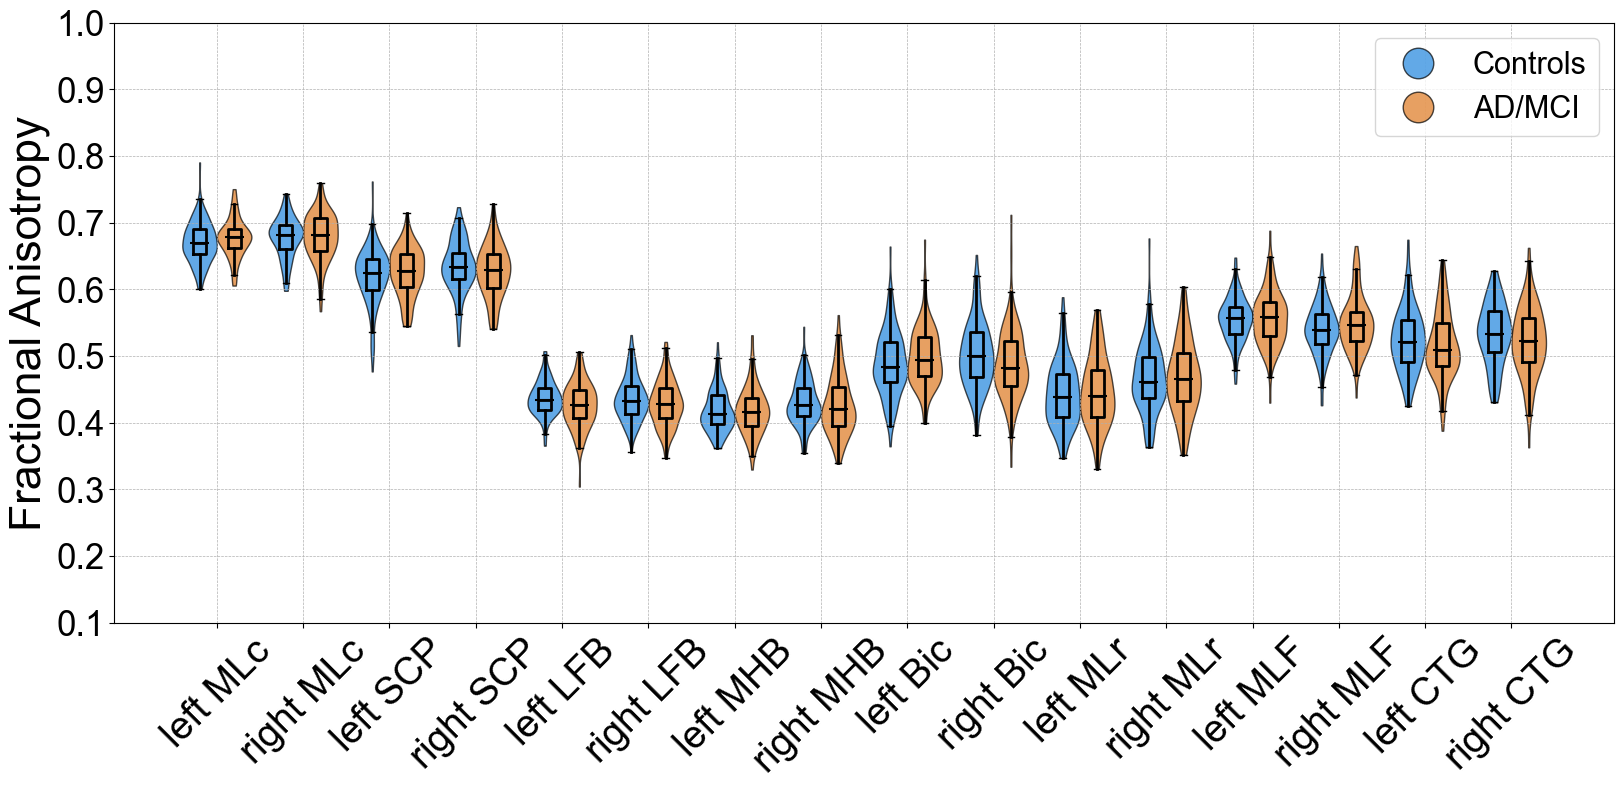

In [8]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_BSB.png'
ylab_name= 'Fractional Anisotropy'
labels = label_names
y_lower = 0.1
y_upper = 1.0
figsize = (25, 10)
controls = controls_bsb
patients = patients_bsb


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  16
label name:  left MLc     uncorrected p_value:  0.611258311004159     corrected p_value:  0.6770575176034418
label name:  right MLc     uncorrected p_value:  0.3274238355107397     corrected p_value:  0.43656511401431963
label name:  left SCP     uncorrected p_value:  0.06231862288461724     corrected p_value:  0.19941959323077516
label name:  right SCP     uncorrected p_value:  0.4539599469664267     corrected p_value:  0.5587199347279098
label name:  left LFB     uncorrected p_value:  0.7865862657045981     corrected p_value:  0.7865862657045981
label name:  right LFB     uncorrected p_value:  0.013937961063925676     corrected p_value:  0.07433579234093694
label name:  left MHB     uncorrected p_value:  0.0033688517925898223     corrected p_value:  0.02695081434071858
label name:  right MHB     uncorrected p_value:  0.0015010851670256324     corrected p_value:  0.024017362672410118
label name:  left Bic     uncorrected p_value:  0.11615176662379313     corrected p

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


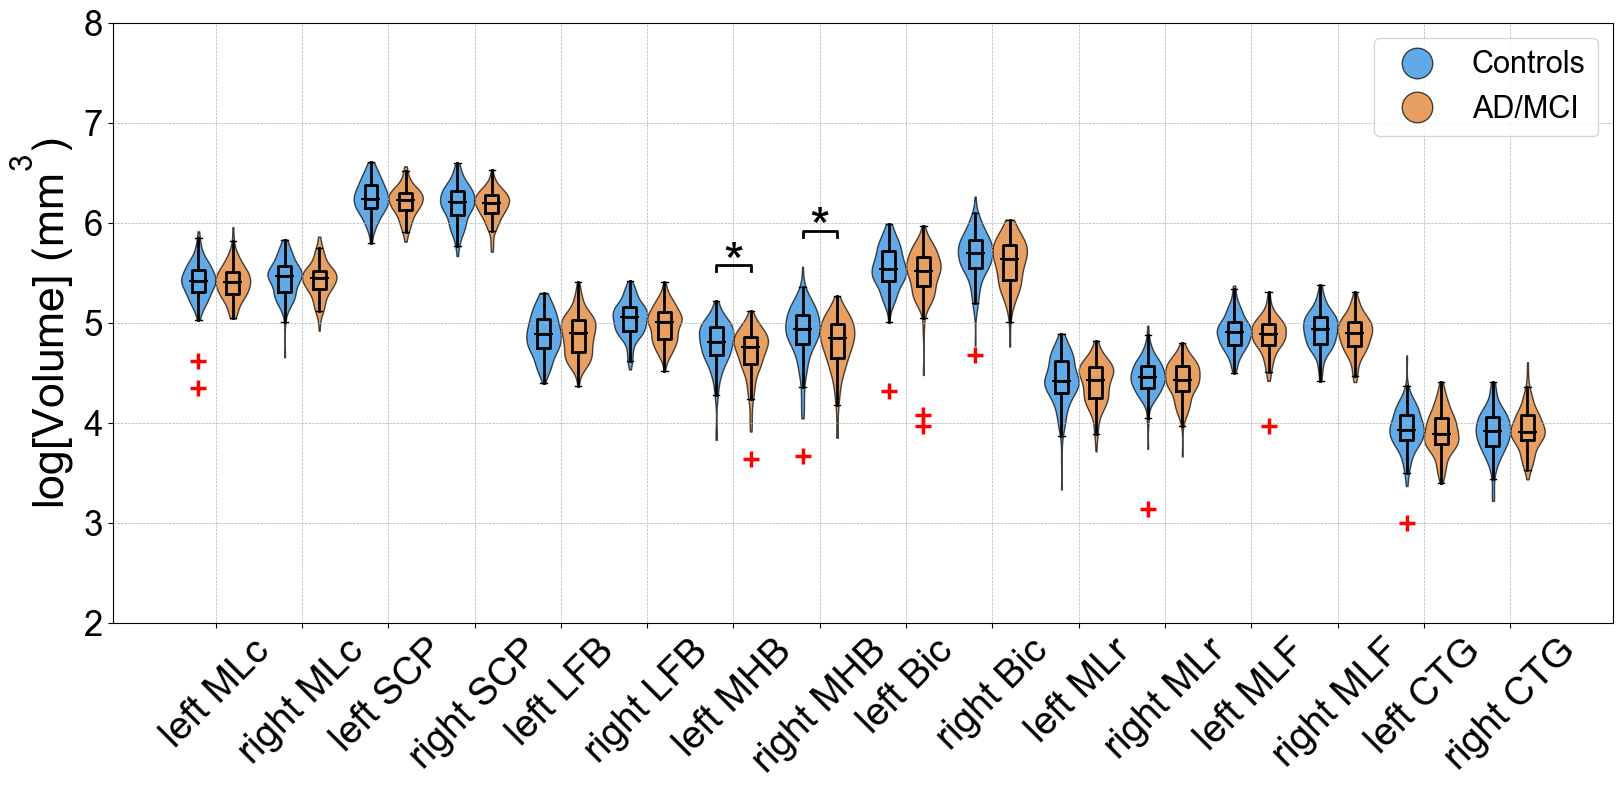

In [9]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_BSB_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = label_names
y_lower = 2
y_upper = 8
figsize = (25, 10)
controls = np.log(controls_bsb_volume)
patients = np.log(patients_bsb_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [10]:
for case in case_list_control:
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting control: ",case)
    if os.path.isfile(dir_fa):
        for tract in tractseg_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                #print("tract " + tract + " exists!")
                x = 1
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
        
for case in case_list_patient:
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_fa):
        for tract in tractseg_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                #print("tract " + tract + " exists!")
                x = 1
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
            

starting control:  002_S_6103
starting control:  003_S_6014
starting control:  003_S_6915
starting control:  011_S_6714
starting control:  016_S_6892
starting control:  020_S_6470
starting control:  032_S_4429
starting control:  033_S_1016
starting control:  033_S_7114
starting control:  037_S_6046
starting control:  041_S_6292
starting control:  068_S_4340
starting control:  002_S_1261
starting control:  002_S_6404
starting control:  003_S_6067
starting control:  003_S_6924
starting control:  011_S_7028
starting control:  016_S_6931
starting control:  020_S_6504
starting control:  032_S_6211
starting control:  033_S_1098
starting control:  037_S_6115
starting control:  041_S_6314
starting control:  068_S_4424
starting control:  941_S_4292
starting control:  002_S_1280
starting control:  002_S_6456
starting control:  003_S_6092
starting control:  012_S_4643
starting control:  016_S_6934
starting control:  020_S_6513
starting control:  033_S_4179
starting control:  037_S_6144
starting c

In [11]:
### check if tractseg vols exist
case_list_control_pruned_tractseg = case_list_control
case_list_patient_pruned_tractseg = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_tractseg))
controls_bsb_tractseg = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_volume_list)))

controls_bsb_tractseg_volume = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg_volume = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_volume_list)))


counter = 0
for case in case_list_control_pruned_tractseg:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')

                      
    counter_tract = 0
    for tract in tractseg_volume_list:               
        for tract in tractseg_volume_list:               
            if not os.path.exists(os.path.join(dir_tractseg,tract + "_conformed.nii.gz")):
                print("does not exist: ", tract + "_conformed.nii.gz")
    counter += 1
    

counter = 0
for case in case_list_patient_pruned_tractseg:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    counter_tract = 0
    for tract in tractseg_volume_list:               
        if not os.path.exists(os.path.join(dir_tractseg,tract + "_conformed.nii.gz")):
            print("does not exist: ", tract + "_conformed.nii.gz")
    counter += 1


length of pruned patient cases:  106
starting control:  002_S_6103
starting control:  003_S_6014
starting control:  003_S_6915
starting control:  011_S_6714
starting control:  016_S_6892
starting control:  020_S_6470
starting control:  032_S_4429
starting control:  033_S_1016
starting control:  033_S_7114
starting control:  037_S_6046
starting control:  041_S_6292
starting control:  068_S_4340
starting control:  002_S_1261
starting control:  002_S_6404
starting control:  003_S_6067
starting control:  003_S_6924
starting control:  011_S_7028
starting control:  016_S_6931
starting control:  020_S_6504
starting control:  032_S_6211
starting control:  033_S_1098
starting control:  037_S_6115
starting control:  041_S_6314
starting control:  068_S_4424
starting control:  941_S_4292
starting control:  002_S_1280
starting control:  002_S_6456
starting control:  003_S_6092
starting control:  012_S_4643
starting control:  016_S_6934
starting control:  020_S_6513
starting control:  033_S_4179
sta

In [12]:
case_list_control_pruned_tractseg = case_list_control
case_list_patient_pruned_tractseg = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_tractseg))
controls_bsb_tractseg = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_volume_list)))

controls_bsb_tractseg_volume = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg_volume = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_volume_list)))


counter = 0
for case in case_list_control_pruned_tractseg:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_fa))
    vol_np = vol.get_fdata()
    
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    

                      
    counter_tract = 0
    for tract in tractseg_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()
                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded)
        controls_bsb_tractseg[counter,counter_tract] = mean_diff
        controls_bsb_tractseg_volume[counter,counter_tract] = volm
        if mean_diff == 0:
            print("low FA!")
        counter_tract += 1
    counter += 1
    

counter = 0
for case in case_list_patient_pruned_tractseg:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_fa))
    vol_np = vol.get_fdata()
    
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
 
                      
    counter_tract = 0
    for tract in tractseg_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded)
        patients_bsb_tractseg[counter,counter_tract] = mean_diff
        patients_bsb_tractseg_volume[counter,counter_tract] = volm
        if mean_diff == 0:
            print("low FA!")
        counter_tract += 1
    counter += 1


length of pruned patient cases:  106
starting control:  002_S_6103
starting control:  003_S_6014
starting control:  003_S_6915
starting control:  011_S_6714
starting control:  016_S_6892
starting control:  020_S_6470
starting control:  032_S_4429
starting control:  033_S_1016
starting control:  033_S_7114
starting control:  037_S_6046
starting control:  041_S_6292
starting control:  068_S_4340
starting control:  002_S_1261
starting control:  002_S_6404
starting control:  003_S_6067
starting control:  003_S_6924
starting control:  011_S_7028
starting control:  016_S_6931
starting control:  020_S_6504
starting control:  032_S_6211
starting control:  033_S_1098
starting control:  037_S_6115
starting control:  041_S_6314
starting control:  068_S_4424
starting control:  941_S_4292
starting control:  002_S_1280
starting control:  002_S_6456
starting control:  003_S_6092
starting control:  012_S_4643
starting control:  016_S_6934
starting control:  020_S_6513
starting control:  033_S_4179
 
 

num labels is:  15
label name:  CG_left     uncorrected p_value:  0.9518454372665588     corrected p_value:  0.9598637473305723
label name:  CG_right     uncorrected p_value:  0.4312372489566103     corrected p_value:  0.7655707519462227
label name:  ILF_left     uncorrected p_value:  0.4114771586281253     corrected p_value:  0.7655707519462227
label name:  ILF_right     uncorrected p_value:  0.2717294513769293     corrected p_value:  0.7655707519462227
label name:  FX_left     uncorrected p_value:  0.0026175641299876476     corrected p_value:  0.019631730974907356
label name:  FX_right     uncorrected p_value:  1.6075606469146056e-07     corrected p_value:  2.4113409703719083e-06
label name:  UF_left     uncorrected p_value:  0.4823481082713046     corrected p_value:  0.7655707519462227
label name:  UF_right     uncorrected p_value:  0.15352089842773203     corrected p_value:  0.7655707519462227
label name:  CC     uncorrected p_value:  0.5065083817523186     corrected p_value:  0.76

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


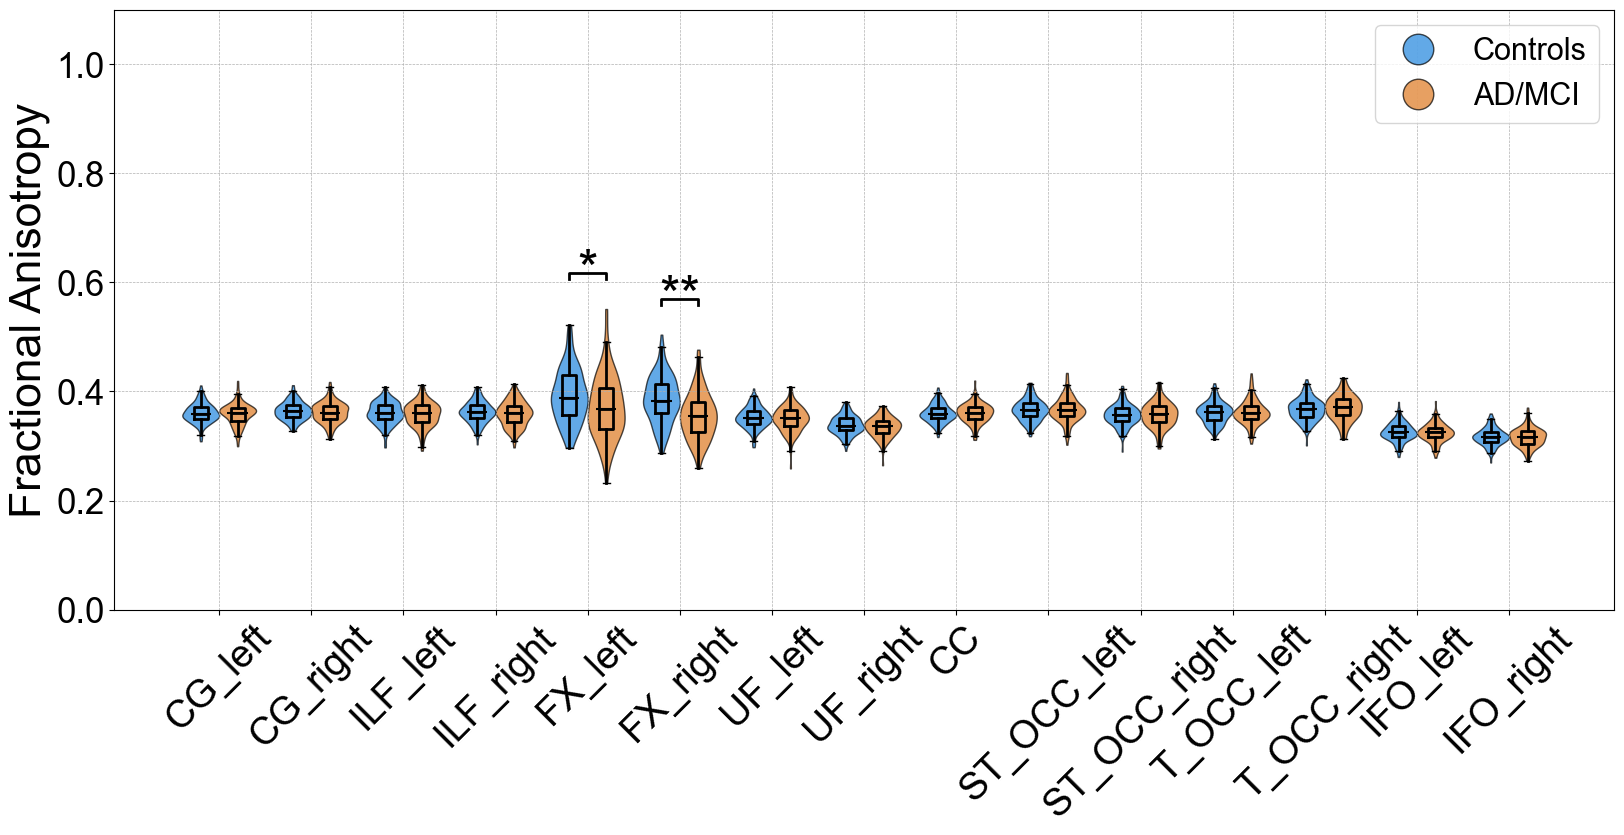

In [13]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_tractseg.png'
ylab_name= 'Fractional Anisotropy'
labels = tractseg_volume_list
y_lower = 0.0
y_upper = 1.1
figsize = (25, 10)
controls = controls_bsb_tractseg
patients = patients_bsb_tractseg


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  15
label name:  CG_left     uncorrected p_value:  0.0016422031620329433     corrected p_value:  0.0030791309288117686
label name:  CG_right     uncorrected p_value:  0.0009418969021469534     corrected p_value:  0.0028256907064408603
label name:  ILF_left     uncorrected p_value:  0.0012430028573172593     corrected p_value:  0.002907679749063472
label name:  ILF_right     uncorrected p_value:  0.02512709256284673     corrected p_value:  0.026921884888764354
label name:  FX_left     uncorrected p_value:  3.913574921681685e-05     corrected p_value:  0.0005870362382522528
label name:  FX_right     uncorrected p_value:  0.0013569172162296204     corrected p_value:  0.002907679749063472
label name:  UF_left     uncorrected p_value:  0.0005197184395457611     corrected p_value:  0.002313287341490799
label name:  UF_right     uncorrected p_value:  0.00022090743856442493     corrected p_value:  0.001656805789233187
label name:  CC     uncorrected p_value:  0.00061687662439754

/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


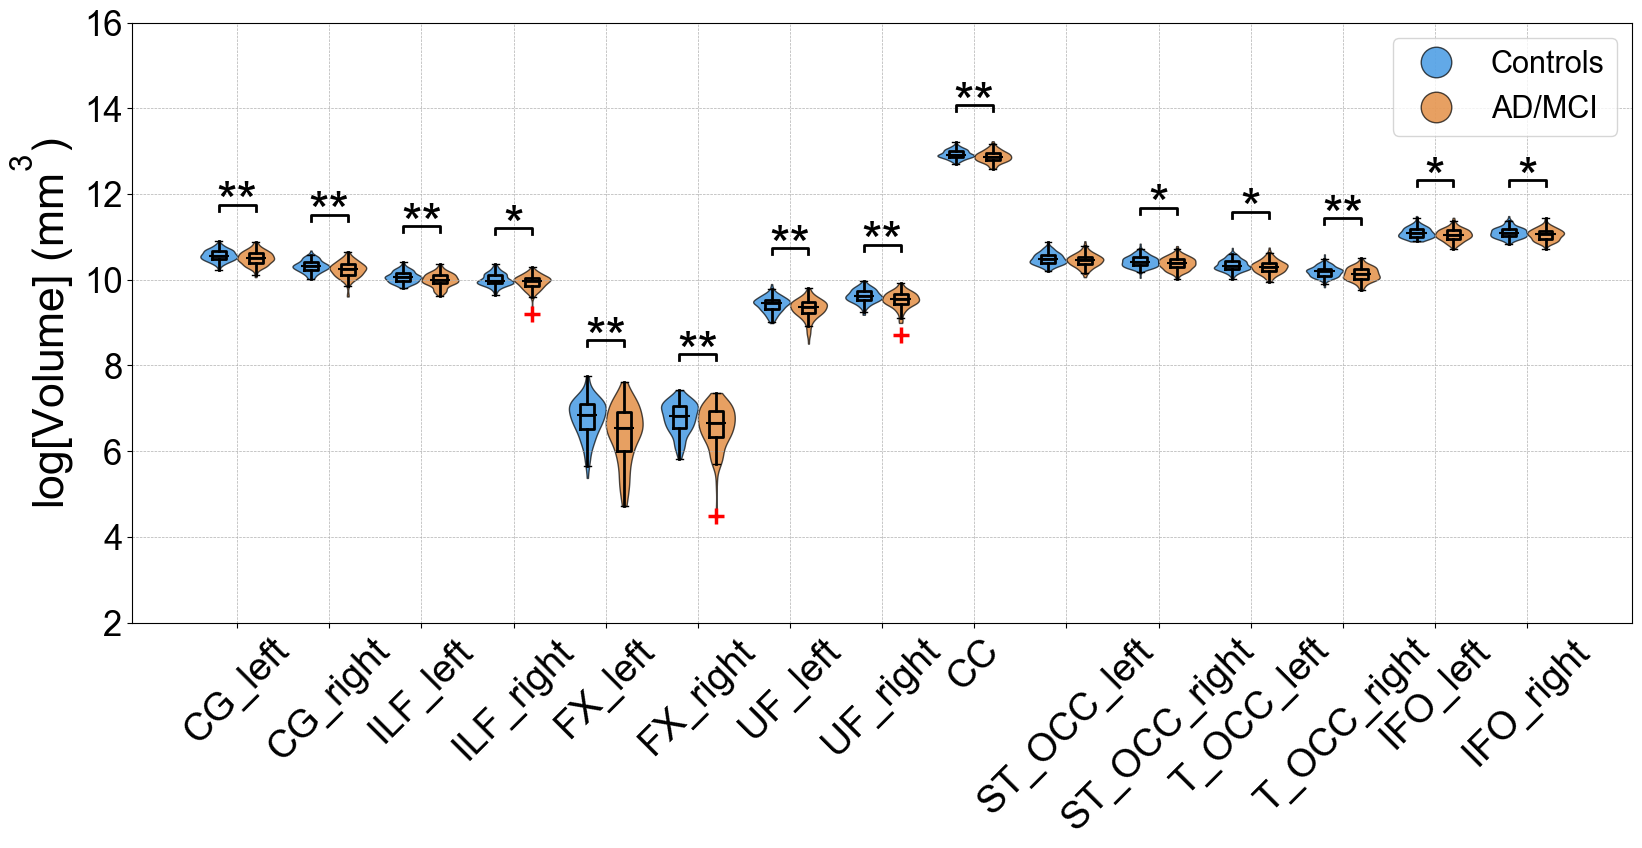

In [14]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_tractseg_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = tractseg_volume_list
y_lower = 2
y_upper = 16
figsize = (25, 10)
controls = np.log(controls_bsb_tractseg_volume)
patients = np.log(patients_bsb_tractseg_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [120]:
###### for brainstem only!!! #######
case_list_control_pruned_brainstem = case_list_control
case_list_patient_pruned_brainstem = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_brainstem))
controls_bsb_brainstem = np.zeros((len(case_list_control_pruned_brainstem),1))
patients_bsb_brainstem = np.zeros((len(case_list_patient_pruned_brainstem),1))

controls_bsb_brainstem_volume = np.zeros((len(case_list_control_pruned_brainstem),1))
patients_bsb_brainstem_volume = np.zeros((len(case_list_patient_pruned_brainstem),1))


counter = 0
for case in case_list_control_pruned_brainstem:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_fa))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)                    
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded, erode_vol=True)
    print("diff: ", mean_diff)
    volm = extract_volume(seg_vol_np_thresholded, erode_vol=True)
    controls_bsb_brainstem[counter,0] = mean_diff
    controls_bsb_brainstem_volume[counter,0] = volm
    counter += 1
    
    

counter = 0
for case in case_list_patient_pruned_brainstem:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_fa))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)                     
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded, erode_vol=True)
    volm = extract_volume(seg_vol_np_thresholded, erode_vol=True)
    patients_bsb_brainstem[counter,0] = mean_diff
    print("diff: ", mean_diff)
    patients_bsb_brainstem_volume[counter,0] = volm
    counter += 1


length of pruned patient cases:  106
starting control:  002_S_6103
diff:  0.383924282909602
starting control:  003_S_6014
diff:  0.37322850076411257
starting control:  003_S_6915
diff:  0.3726103535774036
starting control:  011_S_6714
diff:  0.3419795310574804
starting control:  016_S_6892
diff:  0.3786475622741498
starting control:  020_S_6470
diff:  0.37536766936015087
starting control:  032_S_4429
diff:  0.3647708438797386
starting control:  033_S_1016
diff:  0.38783690118015374
starting control:  033_S_7114
diff:  0.39045030715033235
starting control:  037_S_6046
diff:  0.38652229891209344
starting control:  041_S_6292
diff:  0.39186363100084337
starting control:  068_S_4340
diff:  0.35554312412472183
starting control:  002_S_1261
diff:  0.35824267277173033
starting control:  002_S_6404
diff:  0.3651749923521897
starting control:  003_S_6067
diff:  0.3638047864515593
starting control:  003_S_6924
diff:  0.33741282650931664
starting control:  011_S_7028
diff:  0.37088321008324426
st

diff:  0.3570500797356895
starting patient:  168_S_6827
diff:  0.35027431512102986
starting patient:  168_S_6902
diff:  0.32757854896853317
starting patient:  002_S_4654
diff:  0.40983741643319693
starting patient:  003_S_6479
diff:  0.3891679963662114
starting patient:  012_S_4094
diff:  0.3473361423029941
starting patient:  016_S_6789
diff:  0.3466493834665825
starting patient:  032_S_6728
diff:  0.3493905653521156
starting patient:  033_S_6976
diff:  0.3580558398223599
starting patient:  036_S_6134
diff:  0.3823074041344318
starting patient:  041_S_0679
diff:  0.37441862904413054
starting patient:  137_S_6654
diff:  0.37648890907366594
starting patient:  137_S_6919
diff:  0.3586388961150808
starting patient:  168_S_6619
diff:  0.38716393458913007
starting patient:  168_S_6828
diff:  0.3595221841859034
starting patient:  168_S_6908
diff:  0.3466090155051435
starting patient:  003_S_0908
diff:  0.35960146446343644
starting patient:  003_S_6606
diff:  0.3511342864275052
starting patien

num labels is:  1
label name:  Whole Brainstem     uncorrected p_value:  0.6680940289848776     corrected p_value:  0.6680940289848776


/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/2610567925.py:339: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/2610567925.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


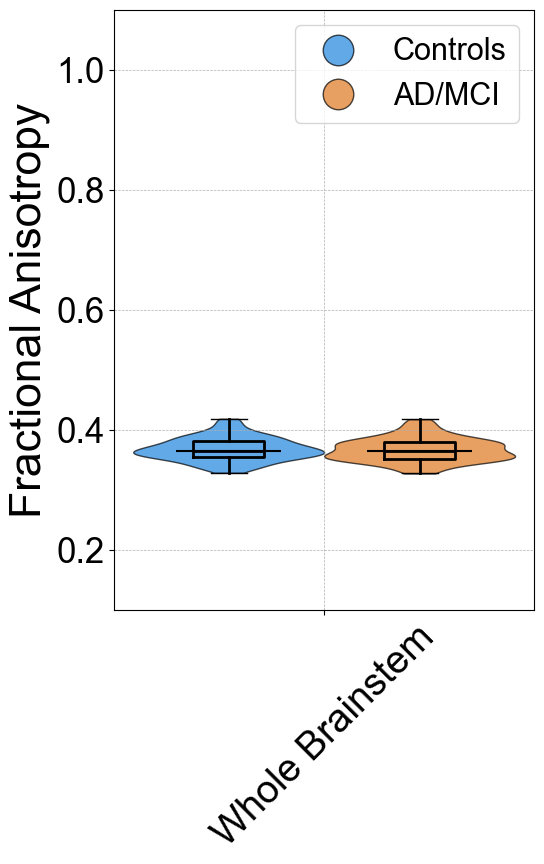

In [130]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_BRAINSTEM.png'
ylab_name= 'Fractional Anisotropy'
labels = ["Whole Brainstem"]
y_lower = 0.1
y_upper = 1.1
figsize = (7, 10)
controls = controls_bsb_brainstem
patients = patients_bsb_brainstem


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  1
label name:  Whole Brainstem     uncorrected p_value:  0.03008353298753889     corrected p_value:  0.03008353298753889


/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/2610567925.py:339: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/2610567925.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


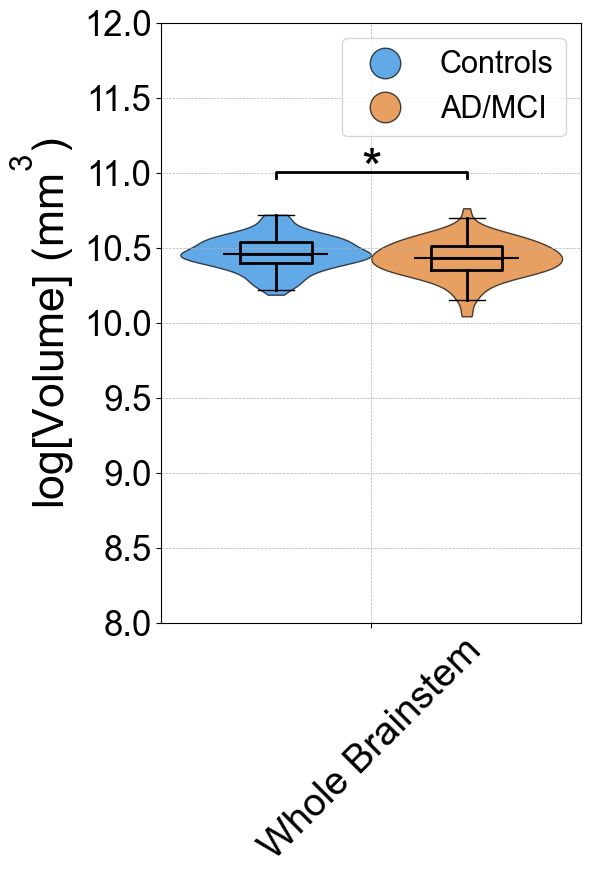

In [131]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_BRAINSTEM_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = ["Whole Brainstem"]
y_lower = 8
y_upper = 12
figsize = (7, 10)
controls = np.log(controls_bsb_brainstem_volume)
patients = np.log(patients_bsb_brainstem_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [18]:
### FOR CORTICAL WHITE MATTER

case_list_control_pruned_cwm = case_list_control
case_list_patient_pruned_cwm = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_cwm))
controls_bsb_cwm = np.zeros((len(case_list_control_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm = np.zeros((len(case_list_patient_pruned_cwm),len(cwm_volume_list)))
controls_bsb_cwm_volume = np.zeros((len(case_list_control_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm_volume = np.zeros((len(case_list_patient_pruned_cwm),len(cwm_volume_list)))


counter = 0
for case in case_list_patient_pruned_cwm:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_fa))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)
    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm_left = extract_volume(seg_vol_np_thresholded_left)
    patients_bsb_cwm[counter,0] = mean_diff_left
    patients_bsb_cwm_volume[counter,0] = volm_left

    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm_right = extract_volume(seg_vol_np_thresholded_right)
    patients_bsb_cwm[counter,1] = mean_diff_right
    patients_bsb_cwm_volume[counter,1] = volm_right
    
    counter += 1



counter = 0
for case in case_list_control_pruned_cwm:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'Axial_DTI',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'Axial_DTI'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_fa))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)
    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm_left = extract_volume(seg_vol_np_thresholded_left)
    controls_bsb_cwm[counter,0] = mean_diff_left
    controls_bsb_cwm_volume[counter,0] = volm_left

    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm_right = extract_volume(seg_vol_np_thresholded_right)
    controls_bsb_cwm[counter,1] = mean_diff_right
    controls_bsb_cwm_volume[counter,1] = volm_right
    
    counter += 1
    
    

length of pruned patient cases:  106
starting patient:  002_S_1155
starting patient:  003_S_6268
starting patient:  011_S_6303
starting patient:  016_S_6708
starting patient:  016_S_6904
starting patient:  032_S_6600
starting patient:  036_S_4538
starting patient:  037_S_6125
starting patient:  137_S_6557
starting patient:  168_S_6541
starting patient:  168_S_6821
starting patient:  168_S_6875
starting patient:  002_S_4229
starting patient:  003_S_6432
starting patient:  011_S_6618
starting patient:  016_S_6771
starting patient:  016_S_6926
starting patient:  032_S_6700
starting patient:  033_S_6889
starting patient:  036_S_6099
starting patient:  037_S_6141
starting patient:  137_S_6576
starting patient:  137_S_6903
starting patient:  168_S_6591
starting patient:  168_S_6827
starting patient:  168_S_6902
starting patient:  002_S_4654
starting patient:  003_S_6479
starting patient:  012_S_4094
starting patient:  016_S_6789
starting patient:  032_S_6728
starting patient:  033_S_6976
sta

num labels is:  2
label name:  left Hemispheric GM     uncorrected p_value:  0.8911234179549273     corrected p_value:  0.9935755582772812
label name:  right Hemispheric GM     uncorrected p_value:  0.9935755582772812     corrected p_value:  0.9935755582772812


/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


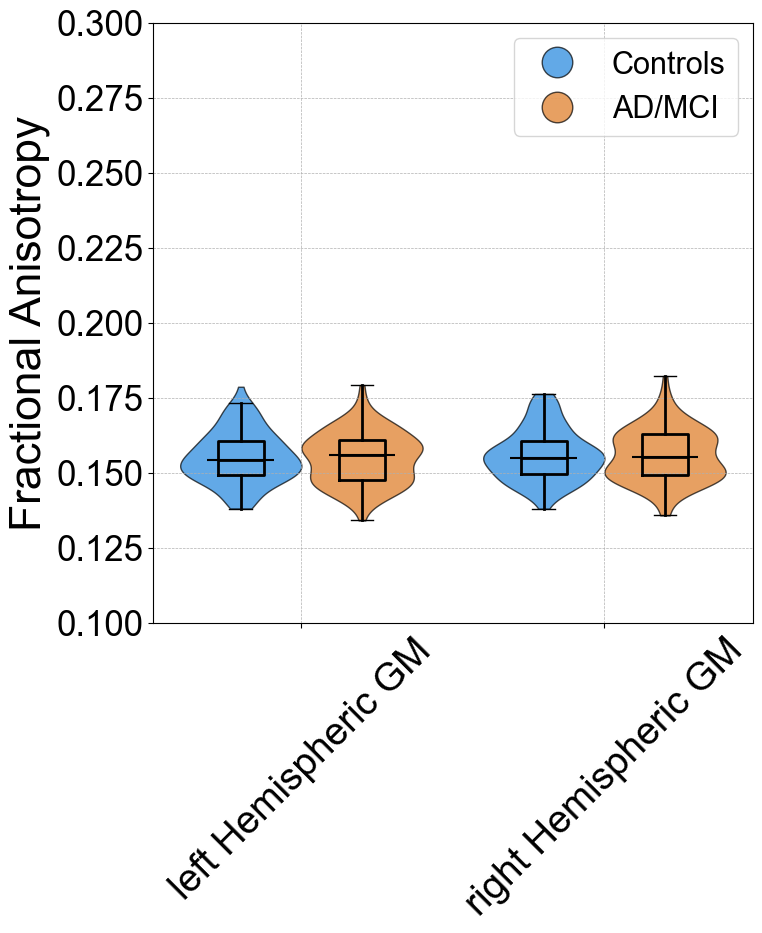

In [19]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_GM.png'
ylab_name= 'Fractional Anisotropy'
labels = ["left Hemispheric GM", "right Hemispheric GM"]
y_lower = 0.1
y_upper = 0.3
figsize = (10, 10)
controls = controls_bsb_cwm
patients = patients_bsb_cwm


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  2
label name:  left Hemispheric GM     uncorrected p_value:  0.009577853133609239     corrected p_value:  0.009577853133609239
label name:  right Hemispheric GM     uncorrected p_value:  0.00496775424221775     corrected p_value:  0.009577853133609239


/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/3205483414.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


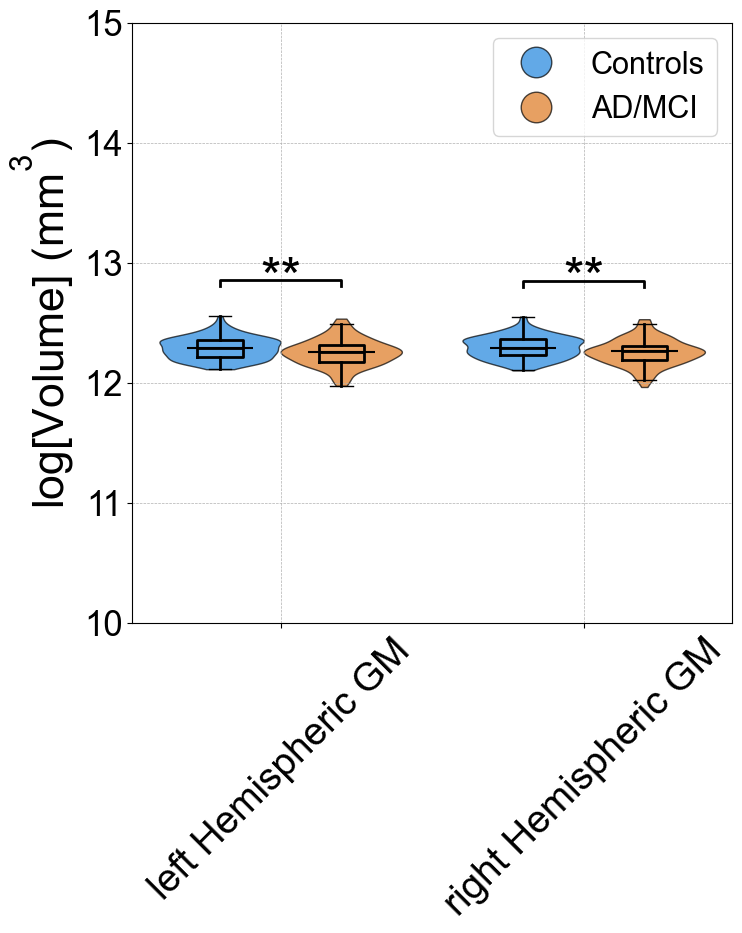

In [20]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/ADNI_violin_GM_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = ["left Hemispheric GM", "right Hemispheric GM"]
y_lower = 10
y_upper = 15
figsize = (10, 10)
controls = np.log(controls_bsb_cwm_volume)
patients = np.log(patients_bsb_cwm_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [132]:
C=''
pen=''
sol=''


####################### for FA ##########################

scaler = StandardScaler()  # normalize the data for classification, only needed for multiple feats (not brainstem)

all_y_test, all_y_scores, fpr, tpr, roc_auc = roc(controls_bsb, 
                                                  patients_bsb, 
                                                  scaler=scaler,
                                                  flip_preds=False,
                                                  C=C, 
                                                  penalty=pen, 
                                                  solver=sol)

all_y_test_tractseg, all_y_scores_tractseg, fpr_tractseg, tpr_tractseg, roc_auc_tractseg = roc(controls_bsb_tractseg, 
                                                                                      patients_bsb_tractseg, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=pen, 
                                                                                      solver=sol)

# single feature so no scaling
all_y_test_brainstem, all_y_scores_brainstem, fpr_brainstem, tpr_brainstem, roc_auc_brainstem = roc(controls_bsb_brainstem, 
                                                                                                   patients_bsb_brainstem, 
                                                                                                   scaler=None,
                                                                                                   flip_preds=True,
                                                                                                   C=C, 
                                                                                                   penalty=pen, 
                                                                                                   solver=sol)


all_y_test_cwm, all_y_scores_cwm, fpr_cwm, tpr_cwm, roc_auc_cwm = roc(controls_bsb_cwm, 
                                                  patients_bsb_cwm, 
                                                  scaler=scaler,
                                                  flip_preds=True,
                                                  C=C, 
                                                  penalty=pen, 
                                                  solver=sol)


####################### for volumes ##########################

all_y_test_volume, all_y_scores_volume, fpr_volume, tpr_volume, roc_auc_volume = roc(controls_bsb_volume, 
                                                                                      patients_bsb_volume, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=pen, 
                                                                                      solver=sol)

all_y_test_tractseg_volume, all_y_scores_tractseg_volume, fpr_tractseg_volume, tpr_tractseg_volume, roc_auc_tractseg_volume = roc(controls_bsb_tractseg_volume, 
                                                                                                                              patients_bsb_tractseg_volume, 
                                                                                                                              scaler=scaler,
                                                                                                                              flip_preds=False,
                                                                                                                              C=C, 
                                                                                                                              penalty=pen, 
                                                                                                                              solver=sol)
# single feature so no scaling
all_y_test_brainstem_volume, all_y_scores_brainstem_volume, fpr_brainstem_volume, tpr_brainstem_volume, roc_auc_brainstem_volume = roc(controls_bsb_brainstem_volume, 
                                                                                                                                   patients_bsb_brainstem_volume, 
                                                                                                                                   scaler=None,
                                                                                                                                   flip_preds=False,
                                                                                                                                   C=C, 
                                                                                                                                   penalty=pen, 
                                                                                                                                   solver=sol)

all_y_test_cwm_volume, all_y_scores_cwm_volume, fpr_cwm_volume, tpr_cwm_volume, roc_auc_cwm_volume = roc(controls_bsb_cwm_volume, 
                                                                                                      patients_bsb_cwm_volume, 
                                                                                                      scaler=scaler,
                                                                                                      flip_preds=False,
                                                                                                      C=C, 
                                                                                                      penalty=pen, 
                                                                                                      solver=sol)



/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/567137697.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


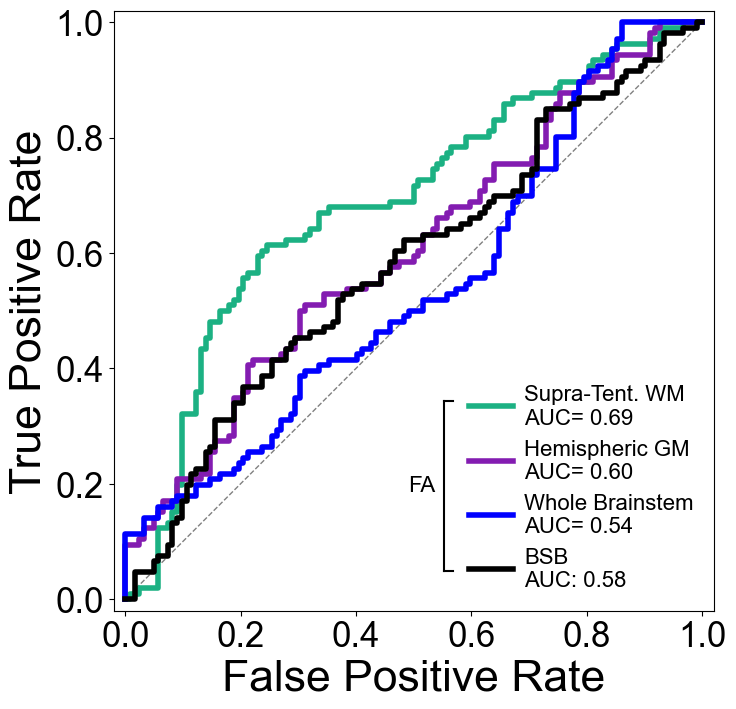

In [133]:
#### plot everything together!

fig = plt.figure(figsize=(10, 10))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg, tpr_tractseg, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm, tpr_cwm, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem, tpr_brainstem, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem))


# Plot BSB ROC curve
plt.plot(fpr, tpr, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)


bracket_x = 0.55
bracket_top = 0.35
bracket_bottom = 0.067 

plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.06, (bracket_top + bracket_bottom) / 2, 'FA', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/ADNI_ROC_FA.png', dpi=300, transparent=True)
plt.show()



/var/folders/w0/z606l31x3cg7w3xkxz_bpy2h0000gn/T/ipykernel_7748/1190024172.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


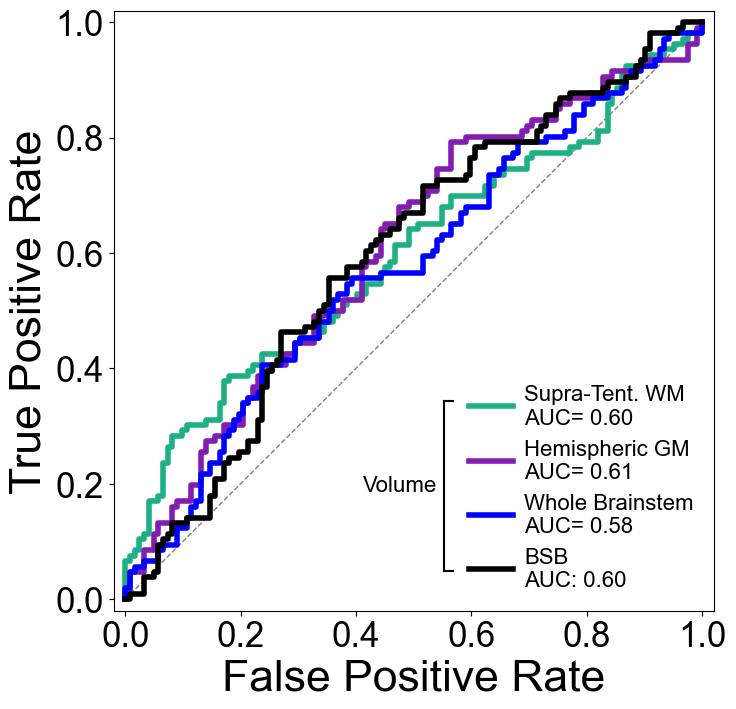

In [134]:
#### plot everything together!

fig = plt.figure(figsize=(10, 10))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_volume, tpr_tractseg_volume, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_volume))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_volume, tpr_cwm_volume, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_volume))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_volume, tpr_brainstem_volume, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_volume))


# Plot BSB ROC curve
plt.plot(fpr_volume, tpr_volume, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_volume))

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)


bracket_x = 0.55 
bracket_top = 0.35  
bracket_bottom = 0.067


plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)

plt.text(bracket_x - 0.135, (bracket_top + bracket_bottom) / 2, 'Volume', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/ADNI_ROC_Volume.png', dpi=300, transparent=True)
plt.show()


In [135]:
p_delong_tractseg_bsb = delong_roc_test(np.array(all_y_test), np.array(all_y_scores),np.array(all_y_scores_tractseg))[0,0]
print("Tractseg-BSB FA p value: ", (10 ** p_delong_tractseg_bsb))


p_delong_bsb_bs = delong_roc_test(np.array(all_y_test), np.array(all_y_scores),np.array(all_y_scores_brainstem))[0,0]
print("Brainstem-BSB FA p value: ", (10 ** p_delong_bsb_bs))

p_delong_bsb_cwm = delong_roc_test(np.array(all_y_test), np.array(all_y_scores),np.array(all_y_scores_cwm))[0,0]
print("CWM-BSB FA p value: ", (10 ** p_delong_bsb_cwm))

aucs are:  [0.58150325 0.68674606]
Tractseg-BSB FA p value:  0.02413876941197973
aucs are:  [0.58150325 0.53897309]
Brainstem-BSB FA p value:  0.4200731803968965
aucs are:  [0.58150325 0.60292298]
CWM-BSB FA p value:  0.6828543023429805


In [136]:
p_delong_tractseg_bsb_volume = delong_roc_test(np.array(all_y_test_volume), np.array(all_y_scores_volume),np.array(all_y_scores_tractseg_volume))[0,0]
print("Tractseg-BSB volume p value: ", (10 ** p_delong_tractseg_bsb_volume))


p_delong_bsb_bs_volume = delong_roc_test(np.array(all_y_test_volume), np.array(all_y_scores_volume),np.array(all_y_scores_brainstem_volume))[0,0]
print("Brainstem-BSB volume p value: ", (10 ** p_delong_bsb_bs_volume))

p_delong_bsb_cwm_volume = delong_roc_test(np.array(all_y_test_volume), np.array(all_y_scores_volume),np.array(all_y_scores_cwm_volume))[0,0]
print("CWM-BSB volume p value: ", (10 ** p_delong_bsb_cwm_volume))

aucs are:  [0.59967522 0.59712341]
Tractseg-BSB volume p value:  0.9535782932238388
aucs are:  [0.59967522 0.57601299]
Brainstem-BSB volume p value:  0.5888294220368792
aucs are:  [0.59967522 0.60918651]
CWM-BSB volume p value:  0.8471708483200168
